In [1]:
"""
state - 3x3 = 9bits (binary representations of the heaps
9 x 128 x 128 x 21 
hidden - relu
out - linear (??), directly q values
making unavailable actions is ok, you get -1 and finish the game

discount gamma = 0.99
buffer of size 10 000
batch 64
update hte target every 500 games
huber loss with delta=1
Adam optimizer

learning rate start with 5 10^(-4)


plots;
average reward and training loss every 250 games
computing Mtest Mopt

modifications:
without the buffer, batch=1

"""

'\nstate - 3x3 = 9bits (binary representations of the heaps\n9 x 128 x 128 x 21 \nhidden - relu\nout - linear (??), directly q values\nmaking unavailable actions is ok, you get -1 and finish the game\n\ndiscount gamma = 0.99\nbuffer of size 10 000\nbatch 64\nupdate hte target every 500 games\nhuber loss with delta=1\nAdam optimizer\n\nlearning rate start with 5 10^(-4)\n\n\nplots;\naverage reward and training loss every 250 games\ncomputing Mtest Mopt\n\nmodifications:\nwithout the buffer, batch=1\n\n'

In [2]:
import random
import itertools
from tqdm import tqdm

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


from nim_env import NimEnv, OptimalPlayer

In [3]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [6]:
class ReplayBuffer:
    def __init__(self, capacity=10*1000):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size=64):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
class DeepQNetwork(nn.Module):
    def __init__(self):
        super(DeepQNetwork, self).__init__()
    
        self.hidden1 = nn.Linear(9, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.output  = nn.Linear(128, 21)
    
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.output(x)
        return x

In [8]:
replay_buffer = ReplayBuffer(capacity=10000)
BATCH_SIZE = 64
GAMMA = 0.99
TARGET_UPDATE_EVERY = 500
LEARNING_RATE = 5*10**-4

policy_net = DeepQNetwork().to(device)
target_net = DeepQNetwork().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

criterion = nn.HuberLoss(delta=1.0)
optimizer = optim.Adam(policy_net.parameters())

In [9]:
def state_to_heaps(x):
    x = x.tolist()
    return tuple(round(4*z[0]+2*z[1]+z[2]) for z in (x[:3], x[3:6], x[6:]))

def heaps_to_state(heaps):
    x = [heaps[0]//4, (heaps[0]%4)//2, heaps[0]&1] + [heaps[1]//4, (heaps[1]%4)//2, heaps[1]&1] + [heaps[2]//4, (heaps[2]%4)//2, heaps[2]&1]
    return torch.tensor(x, dtype=torch.float32)


assert state_to_heaps(heaps_to_state([6,2,7])) == (6,2,7)
assert state_to_heaps(heaps_to_state([0,5,3])) == (0,5,3)

In [10]:
def hot_index_to_action(idx):
    assert 0 <= idx < 21
    return torch.tensor([(torch.div(idx,7,rounding_mode='floor'))+1, (idx%7)+1], device=device)

def select_action(state, eps_treshold=0.1):
    if random.random() > eps_treshold: # move recommended by the network
        with torch.no_grad():
            raw_out = torch.argmax(policy_net(state)).item()
            return hot_index_to_action(raw_out)
    else: # random move
        heaps = state_to_heaps(state)
        heaps_avail = [i for i in range(len(heaps)) if heaps[i] > 0]
        chosen_heap = random.choice(heaps_avail)
        n_obj = random.choice(range(1, heaps[chosen_heap] + 1))
        move = [chosen_heap + 1, n_obj]
        return torch.tensor(move, device=device)

In [11]:
def optimize_model(recent_losses):
    if len(replay_buffer) < BATCH_SIZE:
        return
    
    transitions = replay_buffer.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),
                                 device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(-1, 9)
    state_batch  = torch.cat(batch.state).view(-1, 9)
    action_batch = torch.cat(batch.action).view(-1, 2)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1, torch.tensor([ [(a[0]-1)*7+a[1]-1] for a in action_batch]).to(device))
    
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    recent_losses.append(loss.cpu().item())

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()



def train(against=OptimalPlayer(0.5)):
    # against is None => play against itself
    
    avg_loss_over_time = []
    avg_reward_over_time = []
    recent_losses = []
    recent_rewards = []
    
    env = NimEnv()
    num_games = 20*1000
    for i_game in tqdm(range(num_games)):
        env.reset()
        env.current_player = i_game % 2
        state = heaps_to_state(env.heaps)
        for t in itertools.count():
            
            current_player = env.current_player
            
            if against is None:
                action = select_action(state)
            else:
                if current_player:
                    action = select_action(state)
                else:
                    action = torch.tensor(against.act(env.heaps), device=device)
            
            try:
                next_heaps, done, winner = env.step(action)
                next_state = heaps_to_state(next_heaps)
                if not done:
                    reward = torch.tensor([0], device=device)
                else:
                    # assert current_player == winner
                    reward = torch.tensor([1], device=device)
                    recent_rewards.append(reward.item())
                    replay_buffer.push(state, action, next_state, reward)
                    optimize_model(recent_losses)
                    
                    state = next_step
                    next_state = None
                    reward = torch.tensor([-1], device=device)
                    current_player ^= 1
                    if against is None:
                        action = select_action(state)
                    else:
                        if current_player:
                            action = select_action(state)
                        else:
                            action = torch.tensor(against.act(env.heaps), device=device)
                    
            except: # incorrect move
                reward = torch.tensor([-1], device=device)
                next_state = None
                done = True
            
            recent_rewards.append(reward.item())
            replay_buffer.push(state, action, next_state, reward)
            state = next_state
            optimize_model(recent_losses)
            if done: break

        if (i_game+1) % TARGET_UPDATE_EVERY == 0:
            target_net.load_state_dict(policy_net.state_dict())
        if (i_game+1) % 250 == 0:
            avg_loss_over_time.append(np.array(recent_losses).mean())
            avg_reward_over_time.append(np.array(recent_rewards).mean())
            recent_losses = []
            recent_rewards = []
    
    print('Training done')
    return avg_loss_over_time, avg_reward_over_time


al, ar = train()

100%|██████████| 20000/20000 [15:46<00:00, 21.14it/s]

Training done


In [18]:
class DQNPlayer:
    def __init__(self, policy_net, player=0):
        self.player = player
        self.policy_net = policy_net
        
    def set_player(self, player = 0, j=-1):
        self.player = player
        if j != -1:
            self.player = 0 if j % 2 == 0 else 1
    
    def act(self, heaps, **kwargs):
        with torch.no_grad():
            return hot_index_to_action(self.policy_net(heaps_to_state(heaps)).argmax())

In [19]:
def measure_effectivenes_of_policy(policy, adversary_policy, N_games = 500):
    wins, loses = 0, 0
    for game_i in range(N_games):
        turn = game_i % 2
        policy.set_player(game_i % 2)
        adversary_policy.set_player((game_i % 2) ^ 1)
        
        env = NimEnv(random.randint(0, 10e9))
        
        while not env.end:
            if turn == 0:
                try:
                    env.step(policy.act(env.heaps))
                except:
                    env.winner = policy.player ^ 1
                    break
            else:
                try:
                    env.step(adversary_policy.act(env.heaps))
                except:
                    env.winner = adversary_policy.player ^ 1
                    break    
                    
            turn ^= 1
        
        assert env.winner is not None
        if env.winner == policy.player:
            wins += 1
        else:
            loses += 1
        
    print(f'{wins=}, {loses=}')
    return (wins - loses) / N_games


def M_opt(policy, N_games = 500):
    return measure_effectivenes_of_policy(policy, OptimalPlayer(epsilon=0), N_games)


def M_rand(policy, N_games = 500):
    return measure_effectivenes_of_policy(policy, OptimalPlayer(epsilon=1), N_games)

In [30]:
M_rand(DQNPlayer(policy_net))

wins=267, loses=233


0.068

In [31]:
M_opt(DQNPlayer(policy_net))

wins=4, loses=496


-0.984

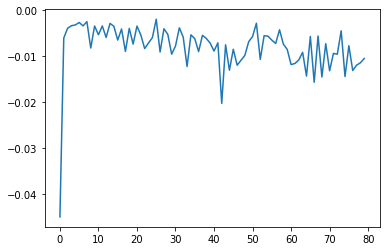

In [22]:
plt.plot(range(len(ar)), ar)
plt.show()

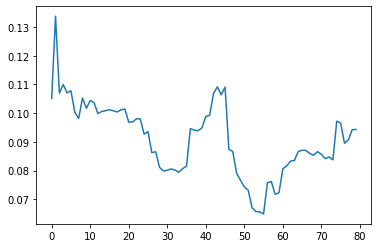

In [23]:
plt.plot(range(len(al)), al)
plt.show()